In [329]:
import polars as pl
import holoviews as hv

df_prices = pl.read_csv('./data/matic-network.csv')
df_prices.columns = ['timestamp', 'price', 'ticker']

df_prices = df_prices.with_columns(
    ema_5 = pl.col('price').ewm_mean(span=5),
    ema_8 = pl.col('price').ewm_mean(span=8),
    ema_13 = pl.col('price').ewm_mean(span=13)
)

df_prices[['price', 'ema_5', 'ema_8', 'ema_13']].plot()


:NdOverlay   [Variable]
   :Curve   [index]   (value)

Signal is to buy when EMA5 crosses from below and sell when the inverse happens.

In [330]:
import numpy as np

df_prices = df_prices.with_columns(
    timestamp = pl.from_epoch(df_prices['timestamp'].cast(pl.Int64), time_unit='ms'),
    ema_bullish = pl.when((pl.col('ema_5') > pl.col('ema_8')) | (pl.col('ema_5') > pl.col('ema_13'))).then(1),
    ema_bearish = pl.when((pl.col('ema_5') < pl.col('ema_8')) | (pl.col('ema_5') < pl.col('ema_13'))).then(1)
)

# apply mask to figure out when to enter
df_prices = df_prices.with_columns(
    buy = pl.when((pl.col('ema_bullish') == 1) & pl.col('ema_bearish').shift(1) == 1).then(1),
    sell = pl.when((pl.col('ema_bearish') == 1) & pl.col('ema_bullish').shift(1) == 1).then(1)
)

def backtest(df: pl.DataFrame):
    cur = None
    trades = []
    for row in df.iter_rows():
        timestamp, price, buy, sell = row[0], row[1], row[8], row[9]
        if not cur:
            if buy:
                cur = 'buy'
                trades.append([timestamp, price, 'buy'])
            elif sell:
                cur = 'sell'
                trades.append([timestamp, price, 'sell'])
        else:
            if cur == 'buy':
                if sell:
                    cur = None
                    trades.append([timestamp, price, 'close buy'])
            elif cur == 'sell':
                if buy:
                    cur = None
                    trades.append([timestamp, price, 'close sell'])
                    
    df_trades = pl.DataFrame(trades, strict=False, orient='row')
    df_trades.columns = ['date', 'price', 'signal']
    return df_trades

df_prices = df_prices.fill_null(0)
df_trades = backtest(df_prices[13:, :])

# calc pnl
df_trades = df_trades.with_columns(
    dif = pl.col('price').pct_change(1)
).with_columns(
    trade_pnl = pl.when(pl.col('signal') == 'close buy').then(pl.col('dif')).when(pl.col('signal') == 'close sell').then(-pl.col('dif'))
)

df_trades

date,price,signal,dif,trade_pnl
datetime[μs],f64,str,f64,f64
2023-08-30 00:00:00,0.593121,"""buy""",null,null
2023-08-31 00:00:00,0.575133,"""close buy""",-0.030328,-0.030328
2023-09-01 00:00:00,0.548926,"""sell""",-0.045567,null
2023-09-20 00:00:00,0.544542,"""close sell""",-0.007986,0.007986
2023-09-21 00:00:00,0.541109,"""buy""",-0.006305,null
…,…,…,…,…
2024-06-06 00:00:00,0.725447,"""close sell""",0.041585,-0.041585
2024-06-08 00:00:00,0.666962,"""sell""",-0.08062,null
2024-07-14 00:00:00,0.53103,"""close sell""",-0.203807,0.203807


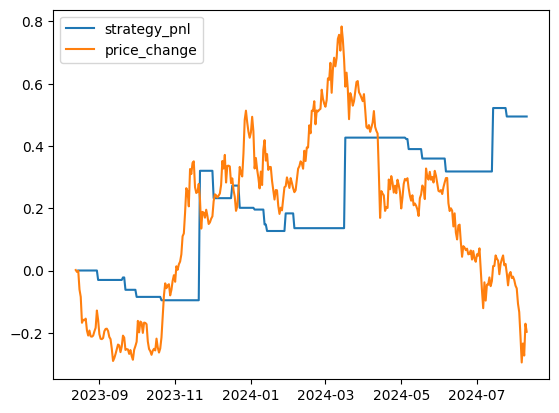

In [331]:
from datetime import timedelta, date
from matplotlib import pyplot as plt

df_range = pl.DataFrame(pl.date_range(date(2023, 8, 15), date(2024, 8, 10), timedelta(days=1), eager=True).alias('date'))

df_trades = df_trades.with_columns(
    time = pl.col('date').dt.date()
)

df_full_range = df_trades.join(df_range, left_on='time', right_on='date', how='right')

# fill zeroes
df_full_range = df_full_range.fill_null(0)
df_full_range = df_full_range.with_columns(
    cumulative_pnl = df_full_range['trade_pnl'].cum_sum()
)

# pct change original price
df_prices = df_prices.with_columns(
    price_change = pl.col('price').pct_change(),
    date = pl.col('timestamp').dt.date()
)

# plot pnl
plt.plot(df_full_range['date_right'], df_full_range['cumulative_pnl'], label='strategy_pnl')
plt.plot(df_prices['date'], df_prices['price_change'].cum_sum(), label = 'price_change')
plt.legend(loc="upper left")
plt.show()